In [3]:
import torch
import torch.nn as nn
from torch.utils import data
from mds189 import Mds189
import numpy as np
from skimage import io, transform
# import ipdb
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import time
start = time.time()

In [4]:
# Helper functions for loading images.
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)

In [21]:
# flag for whether you're training or not
is_train = True
is_key_frame = True # TODO: set this to false to train on the video frames, instead of the key frames
model_to_load = 'model.ckpt' # This is the model to load during testing, if you want to eval a previously-trained model.

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters for data loader
params = {'batch_size': 128,  # TODO: fill in the batch size. often, these are things like 32,64,128,or 256
          'shuffle': True,
          'num_workers': 2
          }
# TODO: Hyper-parameters
num_epochs = 50
learning_rate = 1e-5
# NOTE: depending on your optimizer, you may want to tune other hyperparameters as well

In [22]:
# Datasets
# TODO: put the path to your train, test, validation txt files
if is_key_frame:
    label_file_train =  'dataloader_files/keyframe_data_train.txt'
    label_file_val  =  'dataloader_files/keyframe_data_val.txt'
    # NOTE: the kaggle competition test data is only for the video frames, not the key frames
    # this is why we don't have an equivalent label_file_test with keyframes
else:
    label_file_train = 'dataloader_files/videoframe_data_train.txt'
    label_file_val = 'dataloader_files/videoframe_data_val.txt'
    label_file_test = 'dataloader_files/videoframe_data_test.txt'

In [27]:
# TODO: you should normalize based on the average image in the training set. This shows
# an example of doing normalization
mean = np.array([134.010302198, 118.599587912, 102.038804945]) / 255
std = np.array([23.5033438916, 23.8827343458, 24.5498666589]) / 255
# TODO: if you want to pad or resize your images, you can put the parameters for that below.
pad = 2

# Generators
# NOTE: if you don't want to pad or resize your images, you should delete the Pad and Resize
# transforms from all three _dataset definitions.
train_dataset = Mds189(label_file_train,loader=default_loader,transform=transforms.Compose([
                                               transforms.Pad(pad),    # TODO: if you want to pad your images
                                               # transforms.Resize(requires_parameters), # TODO: if you want to resize your images
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
train_loader = data.DataLoader(train_dataset, **params)

val_dataset = Mds189(label_file_val,loader=default_loader,transform=transforms.Compose([
                                               transforms.Pad(pad),
                                               # transforms.Resize(),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
val_loader = data.DataLoader(val_dataset, **params)

if not is_key_frame:
    test_dataset = Mds189(label_file_test,loader=default_loader,transform=transforms.Compose([
                                                   transforms.Pad(pad),
                                                   # transforms.Resize(),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                                               ]))
    test_loader = data.DataLoader(test_dataset, **params)


# SimpleNet

In [24]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(114 * 226 * 6, 8)
        
    def forward(self, x):
        output = x
        output = self.pool(F.relu(self.conv1(output)))
        output = output.view(-1, np.product(output.size()[1:]))
        output = F.relu(self.fc1(output))
        
        return output

snet = SimpleNet().to(device)

In [26]:
# Train the model
model = snet
# Loss and optimizer
criterion =  nn.CrossEntropyLoss()   #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
loss_list = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels)
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.
        loss_list.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print('Time: {}'.format(end - start))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels) in test_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices

# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

# TODO: you'll need to run the forward pass on the kaggle competition images, and save those results to a csv file.
if not is_key_frame:
    # your code goes here!
    pass

# Save the model checkpoint
torch.save(model.state_dict(), 'snet.ckpt')


Beginning training..
epoch 0
Epoch [1/50], Step [4/23], Loss: 1.6572
Epoch [1/50], Step [8/23], Loss: 1.8238
Epoch [1/50], Step [12/23], Loss: 1.7775
Epoch [1/50], Step [16/23], Loss: 1.7190
Epoch [1/50], Step [20/23], Loss: 1.8727
epoch 1
Epoch [2/50], Step [4/23], Loss: 1.6564
Epoch [2/50], Step [8/23], Loss: 1.7491
Epoch [2/50], Step [12/23], Loss: 1.6410
Epoch [2/50], Step [16/23], Loss: 1.7528
Epoch [2/50], Step [20/23], Loss: 1.7979
epoch 2
Epoch [3/50], Step [4/23], Loss: 1.6577
Epoch [3/50], Step [8/23], Loss: 1.6299
Epoch [3/50], Step [12/23], Loss: 1.7411
Epoch [3/50], Step [16/23], Loss: 1.6248
Epoch [3/50], Step [20/23], Loss: 1.7850
epoch 3
Epoch [4/50], Step [4/23], Loss: 1.6104
Epoch [4/50], Step [8/23], Loss: 1.5209
Epoch [4/50], Step [12/23], Loss: 1.5099
Epoch [4/50], Step [16/23], Loss: 1.7398
Epoch [4/50], Step [20/23], Loss: 1.5049
epoch 4
Epoch [5/50], Step [4/23], Loss: 1.5923
Epoch [5/50], Step [8/23], Loss: 1.5720
Epoch [5/50], Step [12/23], Loss: 1.4906
Epoch 

KeyboardInterrupt: 

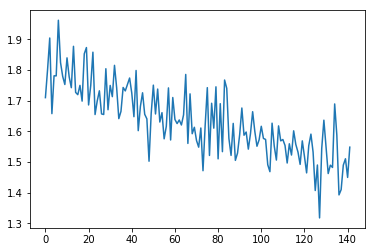

In [37]:
plt.plot(np.arange(1, len(loss_list) * ), loss_list)

# Neural Net

In [30]:
# TODO: one way of defining your model architecture is to fill in a class like NeuralNet()
# NOTE: you should not overwrite the models you try whose performance you're keeping track of.
#       one thing you could do is have many different model forward passes in class NeuralNet()
#       and then depending on which model you want to train/evaluate, you call that model's
#       forward pass. this strategy will save you a lot of time in the long run. the last thing
#       you want to do is have to recode the layer structure for a model (whose performance
#       you're reporting) because you forgot to e.g., compute the confusion matrix on its results
#       or visualize the error modes of your (best) model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # you can define some common layers, for example:
        self.conv1 = nn.Conv2d(3, 16, 5) # you should review the definition of nn.Conv2d online
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        # note: input_dimensions and output_dimensions are not defined, they
        # are placeholders to show you what arguments to pass to nn.Linear
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        # now you can use the layers you defined, to write the forward pass, i.e.,
        # network architecture for your model
        x = self.pool(F.relu(self.conv1(x))) # x -> convolution -> ReLU -> max pooling
        x = self.pool(F.relu(self.conv2(x)))
        # Tensors need to be reshaped before going into an fc layer
        # the -1 will correspond to the batch size
        x = x.view(-1, np.product(x.size()[1:]))
        x = F.relu(self.fc1(x)) # x -> fc (affine) layer -> relu
        return x

nnet = NeuralNet().to(device)

In [22]:
# Train the model
model = nnet
# Loss and optimizer
criterion =  nn.CrossEntropyLoss()   #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
loss_list = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels)
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.
        loss_list.append(loss)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print('Time: {}'.format(end - start))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels) in test_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'.format(total, 100 * correct / total))

# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices

# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

# TODO: you'll need to run the forward pass on the kaggle competition images, and save those results to a csv file.
if not is_key_frame:
    # your code goes here!
    pass

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')


Beginning training..
epoch 0


RuntimeError: size mismatch, m1: [64 x 150528], m2: [75 x 8] at /opt/conda/conda-bld/pytorch_1549636813070/work/aten/src/THC/generic/THCTensorMathBlas.cu:266